## Different types of classifications

**Binary classification:**
    
    It is used when there are only two distinct classes and the data we want to classify belongs exclusively to one of those classes, e.g. to classify if a post about a given product as positive or negative.

**Multiclass classification:**
    
    It is used when there are three or more classes and the data we want to classify belongs exclusively to one of those classes, e.g. to classify if a semaphore on an image is red, yellow or green.

**Multilabel classification:**

    It is used when there are two or more classes and the data we want to classify may belong to none of the classes or all of them at the same time, e.g. to classify which traffic signs are contained on an image.

## Predicting Movie Genres using NLP

Movies are not one-dimensional, One movie can span several genres. 

We cannot apply traditional classification algorithms directly on this kind of dataset. Why? Because these algorithms expect a single label for every input, when instead we have multiple labels.

## Problem Statement

Genres tell us what to expect from the movie and our task is to build a model that can predict the genre of a movie using just the plot details (available in text form).

## Dataset

We will use the CMU Movie Summary Corpus open dataset for our project. 
You can download the dataset from the link below:

    http://www.cs.cmu.edu/~ark/personas/

This dataset contains multiple files, but we’ll focus on only two of them for now:

`movie.metadata.tsv`: Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. The movie genre tags are available in this file

`plot_summaries.txt`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the plot summary


## Our Strategy to Build a Movie Genre Prediction Model

We know that we can’t use supervised classification algorithms directly on a multi-label dataset. Therefore, we’ll first have to transform our target variable. Let’s see how to do this using a dummy dataset:

Lets say, X and y are the features and labels, respectively – it is a multi-label dataset. Now, we will use the Binary Relevance approach to transform our target variable, y. We will first take out the unique labels in our dataset:

Unique labels = [ t1, t2, t3, t4, t5 ]

There are 5 unique tags in the data. Next, we need to replace the current target variable with multiple target variables, each belonging to the unique labels of the dataset. Since there are 5 unique labels, there will be 5 new target variables with values 0 and 1.

We will finally make an Automatic Movie Genre Prediction System.

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', None)

**Load Data**

Let’s load the movie metadata file first. Use ‘\t’ as the separator as it is a tab separated file (.tsv):

In [3]:
meta = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.head(3)

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"


The first column is the unique movie id, the third column is the name of the movie, and the last column contains the movie genre(s). We will not use the rest of the columns in this analysis. Let’s add column names to the aforementioned three variables:

In [4]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [5]:
plots = pd.read_csv("MovieSummaries/plot_summaries.txt", sep = '\t', header = None)

In [6]:
# rename columns
plots.columns = ["movie_id","plot"]

In [7]:
plots["plot"] = plots["plot"].str.strip()

In [8]:
plots.head(3)

movie_id  \
0  23890098   
1  31186339   
2  20663735   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [9]:
plots["plot"].loc[0]

"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

Let’s add the movie names and their genres from the movie metadata file by merging the latter into the former based on the movie_id column:

In [10]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   movie_id    81741 non-null  int64  
 1   1           81741 non-null  object 
 2   movie_name  81741 non-null  object 
 3   3           74839 non-null  object 
 4   4           8401 non-null   float64
 5   5           61291 non-null  float64
 6   6           81741 non-null  object 
 7   7           81741 non-null  object 
 8   genre       81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [11]:
plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42303 non-null  int64 
 1   plot      42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [12]:
# merge meta with movies
movies = pd.merge(plots, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head(3)

movie_id  \
0  23890098   
1  31186339   
2  20663735   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

We have added both movie names and genres. However, the genres are in a dictionary notation. It will be easier to work with them if we can convert them into a Python list.

In [13]:
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [14]:
list(json.loads(movies['genre'][0]).values())

['Drama', 'World cinema']

In [15]:
# using apply function to create a new column
movies['genre_new'] = movies.apply(lambda row: list(json.loads(row['genre']).values()), axis = 1)

In [16]:
# Print the DataFrame after addition
# of new column
movies.head(3)

movie_id  \
0  23890098   
1  31186339   
2  20663735   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Check if there are samples that might not contain any genre tags

In [18]:
movies[(movies['genre_new'].str.len() == 0)]

movie_id  \
26     10644072   
205    26003987   
249     9734319   
266    35295429   
311    34638152   
...         ...   
41390  19482489   
41426   6389479   
42021  32920652   
42119  18253063   
42130  30350202   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

We should remove those samples that does not contain any genre tags as they won’t play a part in our model building process

In [19]:
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [20]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

Find out how many movie genres have been covered in this dataset:

In [32]:
# get all genre tags in a list
genres = [] 

# extract genres
for lst in movies_new['genre_new']: 
    genres.append(lst) 

all_genres = [item for sublist in genres for item in sublist]
len(set(all_genres))

363

There are over 363 unique genre tags in our dataset.  

We will use FreqDist() from the nltk library to create a dictionary of genres and their occurrence count across the dataset:

In [33]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

Let’s plot the distribution of the movie genres:

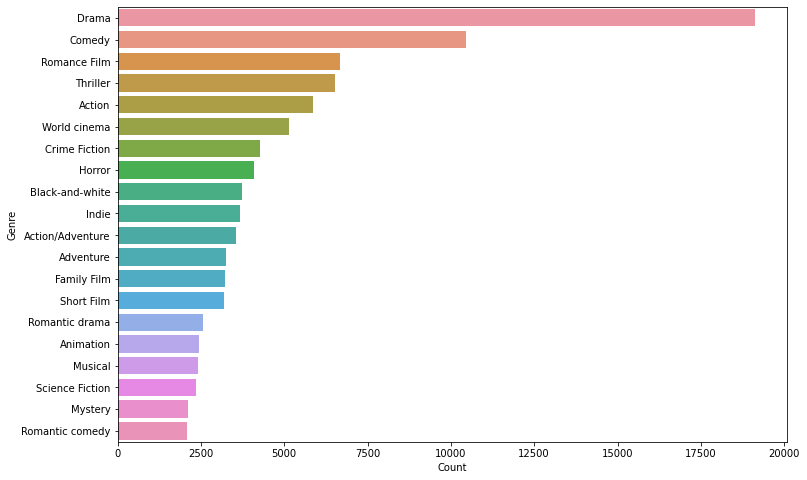

In [39]:
g = all_genres_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(12,8)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
plt.show()

Next, we will perform some very basic text cleaning steps to clean our data a bit.

In [40]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [41]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's check the new versus old movie plots

In [42]:
movies_new[['plot','clean_plot']].head(3)

plot  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Let’s visualize the most frequent words in the movie plots column:

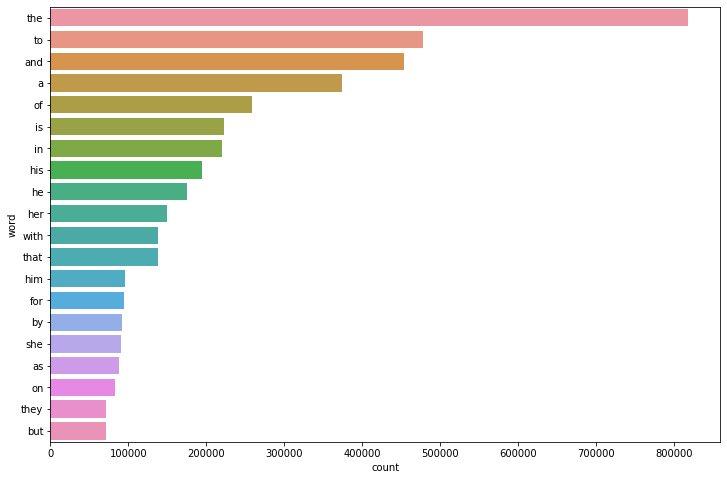

In [45]:
def freq_words(x, terms = 20): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,8)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  plt.show()

# print most frequent words 
freq_words(movies_new['clean_plot'])

Most of the terms in the above plot are stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data). 

Let's remove the stopwords from the plot's text. 

In [46]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Let’s visualize the most frequent words in the movie plots column after removing stop words:

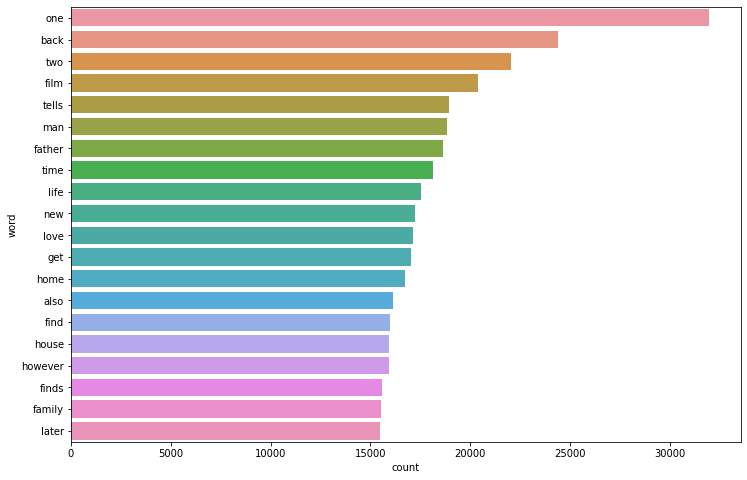

In [47]:
# print most frequent words 
freq_words(movies_new['clean_plot'])

### Converting Text to Features


we will now one hot encode the target variable, i.e., genre_new by using sklearn’s MultiLabelBinarizer( ). Since there are 363 unique genre tags, there are going to be 363 new target variables.

In [48]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [52]:
y.shape

(41793, 363)

**Extracting features from the cleaned version of the movie plots data:**

We will be using TF-IDF features. 

We can use any other feature extraction method such as Bag-of-Words, word2vec, GloVe, or ELMo.

Before creating TF-IDF features, we will split our data into train and validation sets for training and evaluating our model’s performance.

In [53]:
# split dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=101)

In [58]:
# We have used the 10,000 most frequent words in the data as features. 
# Feel free to try any other number for the max_features parameter.

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Building Movie Genre Prediction Model

We will have to build a model for every one-hot encoded target variable. Since we have 363 target variables, we will have to fit 363 different models with the same set of predictors (TF-IDF features).

We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem.

In [55]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [57]:
lr_model = LogisticRegression()
lr_clf = OneVsRestClassifier(lr_model)

In [60]:
# fit model on train data
lr_clf.fit(X_train_tfidf, y_train)

D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 52 is present in all training examples.
  str(classes[c]))
D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 66 is present in all training examples.
  str(classes[c]))
D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
D:\Users\mosharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


OneVsRestClassifier(estimator=LogisticRegression())

In [61]:
# make predictions for validation set
y_pred = lr_clf.predict(X_test_tfidf)

Predictions are binary one-dimensional array of length 363. Basically, it is the one-hot encoded form of the unique genre tags. We will have to find a way to convert it into movie genre tags.

We will use the inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags.

In [66]:
y_pred[5]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
multilabel_binarizer.inverse_transform(y_pred)[5]

('Action', 'Action/Adventure', 'Crime Fiction', 'Thriller')

However, to evaluate our model’s overall performance, we need to take into consideration all the predictions and the entire target variable of the validation set.

In [68]:
# evaluate performance
f1_score(y_test, y_pred, average="micro")

0.3147879290677175

In [89]:
from sklearn.metrics import hamming_loss, accuracy_score

In [90]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Hamming Loss: ", hamming_loss(y_test, y_pred))

Accuracy Score:  0.07165928938868285
Hamming Loss:  0.008710362167169746


There is a more appropriate metric that can be used to measure how good the model is predicting the presence of each aspect independently, this metric is called **hamming loss**, and it is equal to **the number of incorrect prediction divided by the total number of predictions where the output of the model may contain one or more predictions**, it is important to note that unlikely accuracy in hamming loss the smaller the result is the better is the model. 

- We get a decent F1 score of 0.315. These predictions were made based on a threshold value of 0.5, which means that the probabilities greater than or equal to 0.5 were converted to 1’s and the rest to 0’s.

- Let’s try to change this threshold value and see if that improves our model’s score:

In [69]:
# predict probabilities
y_pred_prob = lr_clf.predict_proba(X_test_tfidf)

In [70]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [71]:
# evaluate performance
f1_score(y_test, y_pred_new, average="micro")

0.43941482685541444

In [91]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred_new))
print("Hamming Loss: ", hamming_loss(y_test, y_pred_new))

Accuracy Score:  0.06412250269170953
Hamming Loss:  0.008978956384583417


### Create Inference Function

We have to take care of the new data or new movie plots that will come in the future. 

Our movie genre prediction system should be able to take a movie plot in raw form as input and generate its genre tag(s).

To achieve this, let’s build an inference function. It will take a movie plot text and follow the below steps:

- Clean the text
- Remove stopwords from the cleaned text
- Extract features from the text
- Make predictions
- Return the predicted movie genre tags

In [72]:
def infer_tags(plot_text):
    plot_text = clean_text(plot_text)
    plot_text = remove_stopwords(plot_text)
    plot_text_vec = tfidf_vectorizer.transform([plot_text])
    plot_text_pred = lr_clf.predict(plot_text_vec)
    return multilabel_binarizer.inverse_transform(plot_text_pred)

Testing this inference function on a few samples from our validation set:

In [88]:
for i in range(3): 
    k = X_test.sample(1).index[0] 
    print("Movie: ", movies_new['movie_name'][k]) 
    print("Predicted genre: ", infer_tags(X_test[k])) 
    print("Actual genre: ",movies_new['genre_new'][k])
    print("\n")

Movie:  Mussolini and I
Predicted genre:  [('Drama',)]
Actual genre:  ['Biopic [feature]', 'Drama', 'Political drama', 'Docudrama', 'War film']


Movie:  Open Season 2
Predicted genre:  [('Comedy', 'Family Film')]
Actual genre:  ['Adventure', "Children's/Family", 'Animation', 'Comedy', 'Family Film', 'Family-Oriented Adventure']


Movie:  Paroma
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama']


